In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler
from datetime import *

# Load Data

In [28]:
df = pd.read_csv("./AMD.csv")
final_data = df[::-1].reset_index(drop=True)
final_data = final_data.drop(columns="change")
final_data.head()

,timestamp,open,high,low,close,volume
0,1999-11-01,19.94,20.44,19.88,20.31,1563700
1,1999-11-02,20.31,20.81,20.31,20.56,1898100
2,1999-11-03,20.69,21.50,20.56,21.31,2236000
3,1999-11-04,21.13,21.31,19.94,20.63,2415000
4,1999-11-05,20.75,21.38,20.25,21.25,2148000


# Visualize Data

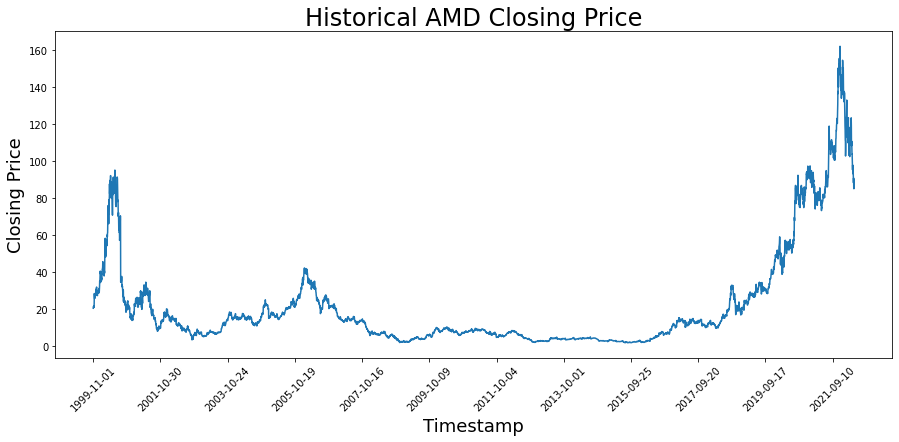

In [29]:
plt.figure(figsize = (15,6))
plt.plot(final_data["timestamp"], final_data["close"])
plt.xticks(range(0,final_data.shape[0], 500), final_data['timestamp'].loc[::500],rotation=45)
plt.xlabel('Timestamp',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)
plt.title("Historical AMD Closing Price", fontsize=24)
plt.savefig("HistoricalAMD.jpg")
plt.show()

# Data Preprocessing

In [30]:
# 1. Filter out the closing market price data
close_data = final_data.filter(['close'])
 
# 2. Convert the data into array for easy evaluation
dataset = close_data.values
 
# 3. Scale/Normalize the data to make all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
# 4. Creating training data size : 75% of the data
training_data_len = math.ceil(len(dataset) *.75)
train_data = scaled_data[0:training_data_len  , : ]
 
# 5. Separating the data into x and y data
x_train_data=[]
y_train_data =[]
for i in range(60,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-60:i,0])
    y_train_data.append(train_data[i,0])
 
    # 6. Converting the training x and y values to numpy arrays
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
 
    # 7. Reshaping training s and y data to make the calculations easier
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))


# Build the LSTM Model

In [31]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


## Compile the Model

In [32]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=5)

Epoch 1/5
4186/4186 [==============================] - 61s 14ms/step - loss: 4.6868e-04
Epoch 2/5
4186/4186 [==============================] - 57s 14ms/step - loss: 1.9260e-04
Epoch 3/5
4186/4186 [==============================] - 56s 13ms/step - loss: 1.6219e-04
Epoch 4/5
4186/4186 [==============================] - 58s 14ms/step - loss: 1.1742e-04
Epoch 5/5
4186/4186 [==============================] - 64s 15ms/step - loss: 1.0936e-04


# Test the Model

In [36]:
# 1. Creating a dataset for testing
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
# 2. Convert the values into arrays for easier computation
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
# 3. Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

## RMSE

In [37]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

2.9397802890173113


/var/folders/60/119q0_pn0fzgzlht5v1c51h00000gn/T/ipykernel_62463/838958780.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


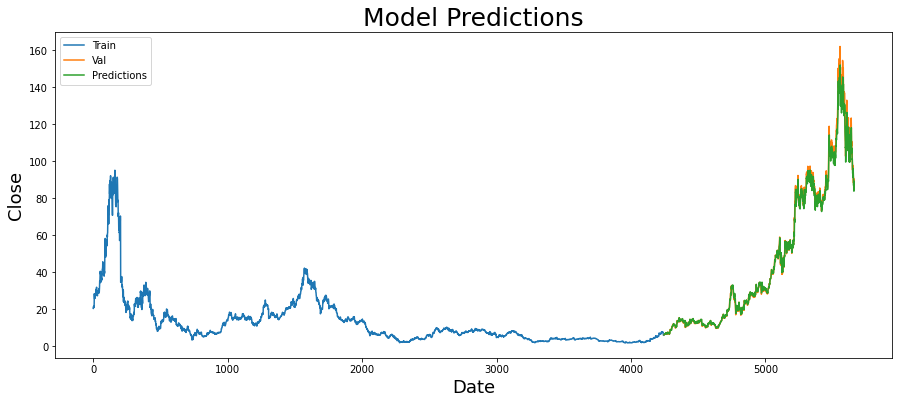

In [38]:
training_data_len = math.ceil(len(dataset) *.75)

train = final_data[:training_data_len]
valid = final_data[training_data_len:]
 
valid['Predictions'] = predictions
 
plt.figure(figsize = (15,6))
plt.title('Model Predictions',fontsize=25)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close',fontsize=18)
 
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
 
plt.savefig("amdPrediction.jpg")
plt.show()